# Set up the class fundementals 

In [1]:
import os, sys
import collections
import numpy as np
import cupy as cp
from scipy.special import logsumexp
import matplotlib.markers as markers
import matplotlib.pyplot as plt
import timeit
from scipy.stats import logistic
from cupyx.scipy.linalg import toeplitz, block_diag
from scipy.stats import median_abs_deviation as mad
import multiprocessing
import cProfile
import itertools
import warnings

warnings.filterwarnings('ignore')  # this is just to hide all the warnings
import rpy2.robjects as robjects

import matplotlib.pyplot as plt  # change font globally to Times

plt.style.use('ggplot')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times New Roman",
    "font.sans-serif": ["Times New Roman"],
    "font.size": 12
})

os.chdir(sys.path[0])  # ensure working direcotry is set same as the file

In [2]:
print("The installed CuPy version is:", cp.__version__)

The installed CuPy version is: 8.3.0


In [3]:
class tensor_computation:
    '''
    This is just a fundemental class used for tensor computation;
    its main purpose here is to serve as a class which LMM_SCAD_MCP can inherent from later. 
    '''
    def __str__(self):
        '''
        Basic declaration for class. 
        '''
        return "This is just a fundemental linear algebra computation setup for class creation in the future steps"

    ######################################  some SCAD and MCP things  #######################################
    def soft_thresholding(self, x, lambda_):
        '''
        To calculate soft-thresholding mapping of a given ONE-DIMENSIONAL tensor, BESIDES THE FIRST TERM (so beta_0 will not be penalized). 
        This function is to be used for calculation involving L1 penalty term later. 
        '''
        return cp.concatenate((cp.array([x[0]]),
                               cp.where(
                                   cp.abs(x[1:]) > lambda_,
                                   x[1:] - cp.sign(x[1:]) * lambda_, 0)))

    def SCAD(self, x, lambda_, a=3.7):
        '''
        To calculate SCAD penalty value;
        #x can be a multi-dimensional tensor;
        lambda_, a are scalars;
        Fan and Li suggests to take a as 3.7 
        '''
        # here I notice the function is de facto a function of absolute value of x, therefore take absolute value first to simplify calculation
        x = cp.abs(x)
        temp = cp.where(
            x <= lambda_, lambda_ * x,
            cp.where(x < a * lambda_,
                     (2 * a * lambda_ * x - x**2 - lambda_**2) / (2 * (a - 1)),
                     lambda_**2 * (a + 1) / 2))
        temp[0] = 0.  # this is to NOT penalize intercept beta later
        return temp

    def SCAD_grad(self, x, lambda_, a=3.7):
        '''
        To calculate the gradient of SCAD wrt. input x; 
        #x can be a multi-dimensional tensor. 
        '''
        # here decompose x to sign and its absolute value for easier calculation
        sgn = cp.sign(x)
        x = cp.abs(x)
        temp = cp.where(
            x <= lambda_, lambda_ * sgn,
            cp.where(x < a * lambda_, (a * lambda_ * sgn - sgn * x) / (a - 1),
                     0))
        temp[0] = 0.  # this is to NOT penalize intercept beta later
        return temp

    def MCP(self, x, lambda_, gamma):
        '''
        To calculate MCP penalty value; 
        #x can be a multi-dimensional tensor. 
        '''
        # the function is a function of absolute value of x
        x = cp.abs(x)
        temp = cp.where(x <= gamma * lambda_, lambda_ * x - x**2 / (2 * gamma),
                        .5 * gamma * lambda_**2)
        temp[0] = 0.  # this is to NOT penalize intercept beta later
        return temp

    def MCP_grad(self, x, lambda_, gamma):
        '''
        To calculate MCP gradient wrt. input x; 
        #x can be a multi-dimensional tensor. 
        '''
        temp = cp.where(
            cp.abs(x) < gamma * lambda_,
            lambda_ * cp.sign(x) - x / gamma, cp.zeros_like(x))
        temp[0] = 0.  # this is to NOT penalize intercept beta later
        return temp

    def SCAD_concave(self, x, lambda_, a=3.7):
        '''
        The value of concave part of SCAD penalty; 
        #x can be a multi-dimensional tensor. 
        '''
        x = cp.abs(x)
        temp = cp.where(
            x <= lambda_, 0.,
            cp.where(x < a * lambda_,
                     (lambda_ * x - (x**2 + lambda_**2) / 2) / (a - 1),
                     (a + 1) / 2 * lambda_**2 - lambda_ * x))
        temp[0] = 0.  # this is to NOT penalize intercept beta later
        return temp

    def SCAD_concave_grad(self, x, lambda_, a=3.7):
        '''
        The gradient of concave part of SCAD penalty wrt. input x; 
        #x can be a multi-dimensional tensor. 
        '''
        sgn = cp.sign(x)
        x = cp.abs(x)
        temp = cp.where(
            x <= lambda_, 0.,
            cp.where(x < a * lambda_, (lambda_ * sgn - sgn * x) / (a - 1),
                     -lambda_ * sgn))
        temp[0] = 0.  # this is to NOT penalize intercept beta later
        return temp

    def MCP_concave(self, x, lambda_, gamma):
        '''
        The value of concave part of MCP penalty; 
        #x can be a multi-dimensional tensor. 
        '''
        # similiar as in MCP
        x = cp.abs(x)
        temp = cp.where(x <= gamma * lambda_, -(x**2) / (2 * gamma),
                        (gamma * lambda_**2) / 2 - lambda_ * x)
        temp[0] = 0.  # this is to NOT penalize intercept beta later
        return temp

    def MCP_concave_grad(self, x, lambda_, gamma):
        '''
        The gradient of concave part of MCP penalty wrt. input x; 
        #x can be a multi-dimensional tensor. 
        '''
        temp = cp.where(
            cp.abs(x) < gamma * lambda_, -x / gamma, -lambda_ * cp.sign(x))
        temp[0] = 0.  # this is to NOT penalize intercept beta later
        return temp

# Graphical Illustrations for SCAD and MCP 

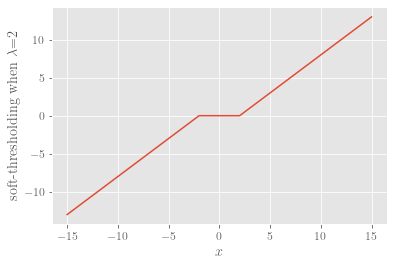

In [4]:
x = cp.arange(-15.1, 15.2, .1)
class_temp = tensor_computation()

plt.plot(x[1:-1].get(), class_temp.soft_thresholding(x, lambda_=2)[1:-1].get())
plt.xlabel(r'$x$')
plt.ylabel(r'soft-thresholding when $\lambda$=2')

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


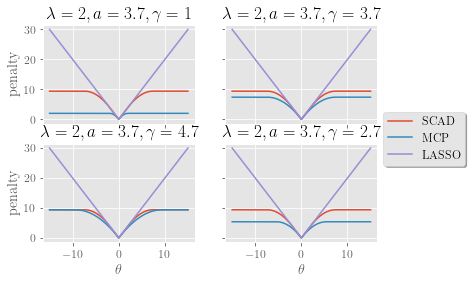

In [5]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(x[1:-1].get(),
               class_temp.SCAD(x, lambda_=2, a=3.7)[1:-1].get(),
               label="SCAD")
axs[0, 0].plot(x[1:-1].get(),
               class_temp.MCP(x, lambda_=2, gamma=1)[1:-1].get(),
               label="MCP")
axs[0, 0].plot(x[1:-1].get(), cp.abs(2 * x)[1:-1].get(), label="LASSO")
axs[0, 0].set_title(r'$\lambda=2,a=3.7,\gamma=1$')
axs[0, 1].plot(x[1:-1].get(),
               class_temp.SCAD(x, lambda_=2, a=3.7)[1:-1].get(),
               label="SCAD")
axs[0, 1].plot(x[1:-1].get(),
               class_temp.MCP(x, lambda_=2, gamma=3.7)[1:-1].get(),
               label="MCP")
axs[0, 1].plot(x[1:-1].get(), cp.abs(2 * x)[1:-1].get(), label="LASSO")
axs[0, 1].set_title(r'$\lambda=2,a=3.7,\gamma=3.7$')
axs[1, 0].plot(x[1:-1].get(),
               class_temp.SCAD(x, lambda_=2, a=3.7)[1:-1].get(),
               label="SCAD")
axs[1, 0].plot(x[1:-1].get(),
               class_temp.MCP(x, lambda_=2, gamma=4.7)[1:-1].get(),
               label="MCP")
axs[1, 0].plot(x[1:-1].get(), cp.abs(2 * x)[1:-1].get(), label="LASSO")
axs[1, 0].set_title(r'$\lambda=2,a=3.7,\gamma=4.7$')
axs[1, 1].plot(x[1:-1].get(),
               class_temp.SCAD(x, lambda_=2, a=3.7)[1:-1].get(),
               label="SCAD")
axs[1, 1].plot(x[1:-1].get(),
               class_temp.MCP(x, lambda_=2, gamma=2.7)[1:-1].get(),
               label="MCP")
axs[1, 1].plot(x[1:-1].get(), cp.abs(2 * x)[1:-1].get(), label="LASSO")
axs[1, 1].set_title(r'$\lambda=2,a=3.7,\gamma=2.7$')

for ax in axs.flat:
    ax.set(xlabel=r'$\theta$', ylabel='penalty')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.legend(loc='center left',
           bbox_to_anchor=(1, 1.05),
           ncol=1,
           fancybox=True,
           shadow=True)
plt.savefig('SCAD_MCP.eps', format='eps', bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


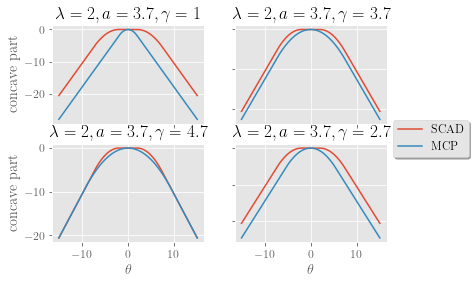

In [6]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(x[1:-1].get(),
               class_temp.SCAD_concave(x, lambda_=2, a=3.7)[1:-1].get(),
               label="SCAD")
axs[0, 0].plot(x[1:-1].get(),
               class_temp.MCP_concave(x, lambda_=2, gamma=1)[1:-1].get(),
               label="MCP")
axs[0, 0].set_title(r'$\lambda=2,a=3.7,\gamma=1$')
axs[0, 1].plot(x[1:-1].get(),
               class_temp.SCAD_concave(x, lambda_=2, a=3.7)[1:-1].get(),
               label="SCAD")
axs[0, 1].plot(x[1:-1].get(),
               class_temp.MCP_concave(x, lambda_=2, gamma=3.7)[1:-1].get(),
               label="MCP")
axs[0, 1].set_title(r'$\lambda=2,a=3.7,\gamma=3.7$')
axs[1, 0].plot(x[1:-1].get(),
               class_temp.SCAD_concave(x, lambda_=2, a=3.7)[1:-1].get(),
               label="SCAD")
axs[1, 0].plot(x[1:-1].get(),
               class_temp.MCP_concave(x, lambda_=2, gamma=4.7)[1:-1].get(),
               label="MCP")
axs[1, 0].set_title(r'$\lambda=2,a=3.7,\gamma=4.7$')
axs[1, 1].plot(x[1:-1].get(),
               class_temp.SCAD_concave(x, lambda_=2, a=3.7)[1:-1].get(),
               label="SCAD")
axs[1, 1].plot(x[1:-1].get(),
               class_temp.MCP_concave(x, lambda_=2, gamma=2.7)[1:-1].get(),
               label="MCP")
axs[1, 1].set_title(r'$\lambda=2,a=3.7,\gamma=2.7$')

for ax in axs.flat:
    ax.set(xlabel=r'$\theta$', ylabel='concave part')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.legend(loc='center left',
           bbox_to_anchor=(1, 1.05),
           ncol=1,
           fancybox=True,
           shadow=True)
plt.savefig('SCAD_MCP_concave.eps', format='eps', bbox_inches='tight')
plt.show()

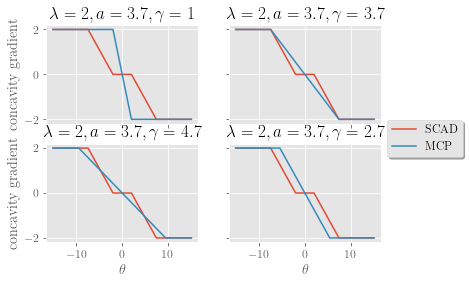

In [7]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(x[1:-1].get(),
               class_temp.SCAD_concave_grad(x, lambda_=2, a=3.7)[1:-1].get(),
               label="SCAD")
axs[0, 0].plot(x[1:-1].get(),
               class_temp.MCP_concave_grad(x, lambda_=2, gamma=1)[1:-1].get(),
               label="MCP")
axs[0, 0].set_title(r'$\lambda=2,a=3.7,\gamma=1$')
axs[0, 1].plot(x[1:-1].get(),
               class_temp.SCAD_concave_grad(x, lambda_=2, a=3.7)[1:-1].get(),
               label="SCAD")
axs[0, 1].plot(x[1:-1].get(),
               class_temp.MCP_concave_grad(x, lambda_=2,
                                           gamma=3.7)[1:-1].get(),
               label="MCP")
axs[0, 1].set_title(r'$\lambda=2,a=3.7,\gamma=3.7$')
axs[1, 0].plot(x[1:-1].get(),
               class_temp.SCAD_concave_grad(x, lambda_=2, a=3.7)[1:-1].get(),
               label="SCAD")
axs[1, 0].plot(x[1:-1].get(),
               class_temp.MCP_concave_grad(x, lambda_=2,
                                           gamma=4.7)[1:-1].get(),
               label="MCP")
axs[1, 0].set_title(r'$\lambda=2,a=3.7,\gamma=4.7$')
axs[1, 1].plot(x[1:-1].get(),
               class_temp.SCAD_concave_grad(x, lambda_=2, a=3.7)[1:-1].get(),
               label="SCAD")
axs[1, 1].plot(x[1:-1].get(),
               class_temp.MCP_concave_grad(x, lambda_=2,
                                           gamma=2.7)[1:-1].get(),
               label="MCP")
axs[1, 1].set_title(r'$\lambda=2,a=3.7,\gamma=2.7$')

for ax in axs.flat:
    ax.set(xlabel=r'$\theta$', ylabel='concavity gradient')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.legend(loc='center left',
           bbox_to_anchor=(1, 1.05),
           ncol=1,
           fancybox=True,
           shadow=True)
plt.show()

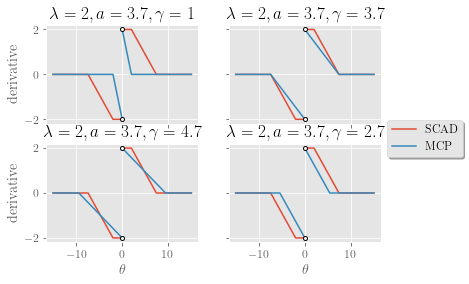

In [8]:
# To plot the derivatives of SCAD and MCP
x[np.abs(x) < 1e-10] = float("nan")
markerstyle = {
    "markersize": 8,
    "markeredgecolor": "black",
    "markerfacecolor": "w",
    "linestyle": "none"
}
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(x[1:-1].get(),
               class_temp.SCAD_grad(x, lambda_=2, a=3.7)[1:-1].get(),
               label="SCAD")
axs[0, 0].plot(x[1:-1].get(),
               class_temp.MCP_grad(x, lambda_=2, gamma=1)[1:-1].get(),
               label="MCP")
axs[0, 0].plot([0, 0], [-2, 2], marker=".", **markerstyle)
axs[0, 0].set_title(r'$\lambda=2,a=3.7,\gamma=1$')
axs[0, 1].plot(x[1:-1].get(),
               class_temp.SCAD_grad(x, lambda_=2, a=3.7)[1:-1].get(),
               label="SCAD")
axs[0, 1].plot(x[1:-1].get(),
               class_temp.MCP_grad(x, lambda_=2, gamma=3.7)[1:-1].get(),
               label="MCP")
axs[0, 1].plot([0, 0], [-2, 2], marker=".", **markerstyle)
axs[0, 1].set_title(r'$\lambda=2,a=3.7,\gamma=3.7$')
axs[1, 0].plot(x[1:-1].get(),
               class_temp.SCAD_grad(x, lambda_=2, a=3.7)[1:-1].get(),
               label="SCAD")
axs[1, 0].plot(x[1:-1].get(),
               class_temp.MCP_grad(x, lambda_=2, gamma=4.7)[1:-1].get(),
               label="MCP")
axs[1, 0].plot([0, 0], [-2, 2], marker=".", **markerstyle)
axs[1, 0].set_title(r'$\lambda=2,a=3.7,\gamma=4.7$')
axs[1, 1].plot(x[1:-1].get(),
               class_temp.SCAD_grad(x, lambda_=2, a=3.7)[1:-1].get(),
               label="SCAD")
axs[1, 1].plot(x[1:-1].get(),
               class_temp.MCP_grad(x, lambda_=2, gamma=2.7)[1:-1].get(),
               label="MCP")
axs[1, 1].plot([0, 0], [-2, 2], marker=".", **markerstyle)
axs[1, 1].set_title(r'$\lambda=2,a=3.7,\gamma=2.7$')

for ax in axs.flat:
    ax.set(xlabel=r'$\theta$', ylabel='derivative')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.legend(loc='center left',
           bbox_to_anchor=(1, 1.05),
           ncol=1,
           fancybox=True,
           shadow=True)
plt.show()

# Implementation

In [9]:
class LM_SCAD_MCP(tensor_computation):
    '''
    This class performs SCAD/MCP pruning on linear models.
    '''
    def __init__(self,
                 design_matrix,
                 outcome,
                 penalty,
                 _lambda,
                 a=3.7,
                 gamma=3,
                 beta_0="NOT DECLARED",
                 tol=1e-4,
                 maxit=5000,
                 L_convex="NOT DECLARED"):
        '''
        Class constructor:
        design_matrix:           the design matrix for the linear models;
        outcome:                 the outcome for the linear model;
        penalty:                 "SCAD" or "MCP";
        _lambda:                 value for lambda; 
        a:                       value for a, only used when penalty set to be "SCAD";
        gamma:                   value for gamma, only used when penalty set to be "MCP";
        beta_0:                  initial values for beta;
        tol:                     tolerance parameter set for beta, this is for the maximum change of beta;
        maxit:                   maximum number of iterations allowed;
        '''
        assert penalty in (
            "SCAD", "MCP"), "Choose between \"SCAD\" or \"MCP\" for penalty"
        assert a > 2, "SCAD penalty parameter, a, needs to be greater than 2"
        assert gamma > 0, "MCP penalty parameter, gamma, needs to be positive"
        assert _lambda > 0, "penalty paramter, lambda_, needs to be positive"
        assert tol > 0, "tol should be postive"
        assert maxit > 0, "maxit is the maximum iteration allowed; which needs to be positive"
        # Construct self
        self.X = design_matrix
        self.y = outcome
        cov = (self.y - cp.mean(self.y)) @ (self.X -
                                            cp.mean(self.X, 0).reshape(1, -1))
        if type(beta_0) == str:
            self.beta = cp.sign(cov)
        else:
            self.beta = beta_0
        self.N = self.X.shape[0]
        # add design matrix column for the intercept, if it's not there already
        if cp.any(
                cp.all(self.X == self.X[0, :], 0)
        ):  # check if design matrix has included a column for intercept or not
            pass
        else:
            intercept_design = cp.ones(self.N).reshape(self.N, 1)
            self.X = cp.concatenate((intercept_design, self.X), 1)
            if type(beta_0) == str:
                self.beta = cp.concatenate((cp.array([0.]), self.beta))
        # passing other parameters
        self.tol = tol
        self.maxit = maxit
        self._lambda = _lambda
        self.penalty = penalty
        #        if penalty == "SCAD":
        self.a = a
        #        else:
        self.gamma = gamma
        self.p = self.X.shape[
            1]  # so here p includes the intercept design matrix column
        self.smooth_grad = cp.ones(self.p)
        self.beta_ag = self.beta.copy()
        self.beta_md = self.beta.copy()
        self.k = 0
        self.FISTA_k = 0
        self.converged = False
        self.obj_value = []
        self.obj_value_ORIGINAL = []
        self.obj_value_AG = []
        self.obj_coord_value = []
        self.opt_alpha = 1
        if type(L_convex) == str:
            self.L_convex = 1 / self.N * cp.max(
                cp.linalg.eigh(self.X @ self.X.T)[0]).item()
        else:
            self.L_convex = L_convex
        self.FISTA_beta = cp.empty_like(self.beta)

    def update_smooth_grad_convex(self):
        '''
        Update the gradient of the smooth convex objective component.
        '''
        self.smooth_grad = 1 / self.N * self.X.T @ (self.X @ self.beta_md -
                                                    self.y)

    def update_smooth_grad_SCAD(self):
        '''
        Update the gradient of the smooth objective component for SCAD penalty.
        '''
        self.update_smooth_grad_convex()
        self.smooth_grad += self.SCAD_concave_grad(self.beta_md,
                                                   lambda_=self._lambda,
                                                   a=self.a)

    def update_smooth_grad_MCP(self):
        '''
        Update the gradient of the smooth objective component for MCP penalty.
        '''
        self.update_smooth_grad_convex()
        self.smooth_grad += self.MCP_concave_grad(self.beta_md,
                                                  lambda_=self._lambda,
                                                  gamma=self.gamma)

    def eval_obj_SCAD(self, x_temp, obj_value_name):
        '''
        evaluate value of the objective function.
        '''
        error = self.y - self.X @ x_temp
        obj_value_name += [(error.T @ error) / (2 * self.N) +
                           cp.sum(self.SCAD(x_temp, self._lambda, self.a))]

    def eval_obj_MCP(self, x_temp, obj_value_name):
        '''
        evaluate value of the objective function.
        '''
        error = self.y - self.X @ x_temp
        obj_value_name += [(error.T @ error) / (2 * self.N) +
                           cp.sum(self.MCP(x_temp, self._lambda, self.gamma))]

    def UAG_LM_SCAD_MCP(self):
        '''
        Carry out the optimization.
        '''
        if self.penalty == "SCAD":
            L = max([self.L_convex, 1 / (self.a - 1)])
            self.opt_beta = .99 / L
            self.eval_obj_SCAD(self.beta_md, self.obj_value)
            self.eval_obj_SCAD(self.beta, self.obj_value_ORIGINAL)
            self.eval_obj_SCAD(self.beta_ag, self.obj_value_AG)
            while not self.converged:
                self.k += 1
                if self.k <= self.maxit:
                    #self.opt_alpha = 2/(self.k+1)**0.3 #parameter setting based on Ghadimi and Lan's exemplified Lemma
                    #self.opt_lambda = self.k/2*self.opt_beta #parameter setting based on Ghadimi and Lan's exemplified Lemma
                    self.opt_alpha = 2 / (
                        1 + cp.sqrt(1 + 4 / self.opt_alpha**2)
                    )  #parameter settings based on minimizing Ghadimi and Lan's rate of convergence error upper bound
                    self.opt_lambda = self.opt_beta / self.opt_alpha  #parameter settings based on minimizing Ghadimi and Lan's rate of convergence error upper bound
                    self.beta_md = (
                        1 - self.opt_alpha
                    ) * self.beta_ag + self.opt_alpha * self.beta
                    self.update_smooth_grad_SCAD()
                    self.beta = self.soft_thresholding(
                        self.beta - self.opt_lambda * self.smooth_grad,
                        self.opt_lambda * self._lambda)
                    self.beta_ag = self.soft_thresholding(
                        self.beta_md - self.opt_beta * self.smooth_grad,
                        self.opt_beta * self._lambda)
                    self.converged = cp.all(
                        cp.max(
                            cp.abs(self.beta_md - self.beta_ag) /
                            self.opt_beta) < self.tol).item()
                    self.eval_obj_SCAD(self.beta_md, self.obj_value)
                    self.eval_obj_SCAD(self.beta, self.obj_value_ORIGINAL)
                    self.eval_obj_SCAD(self.beta_ag, self.obj_value_AG)
                else:
                    break
        else:
            L = max([self.L_convex, 1 / self.gamma])
            self.opt_beta = .99 / L
            self.eval_obj_MCP(self.beta_md, self.obj_value)
            self.eval_obj_MCP(self.beta, self.obj_value_ORIGINAL)
            self.eval_obj_MCP(self.beta_ag, self.obj_value_AG)
            while not self.converged:
                self.k += 1
                if self.k <= self.maxit:
                    #self.opt_alpha = 2/(self.k+1) #parameter setting based on Ghadimi and Lan's exemplified Lemma
                    #self.opt_lambda = self.k/2*self.opt_beta #parameter setting based on Ghadimi and Lan's exemplified Lemma
                    self.opt_alpha = 2 / (
                        1 + cp.sqrt(1 + 4 / self.opt_alpha**2)
                    )  #parameter settings based on minimizing Ghadimi and Lan's rate of convergence error upper bound
                    self.opt_lambda = self.opt_beta / self.opt_alpha  #parameter settings based on minimizing Ghadimi and Lan's rate of convergence error upper
                    self.beta_md = (
                        1 - self.opt_alpha
                    ) * self.beta_ag + self.opt_alpha * self.beta
                    self.update_smooth_grad_MCP()
                    self.beta = self.soft_thresholding(
                        self.beta - self.opt_lambda * self.smooth_grad,
                        self.opt_lambda * self._lambda)
                    self.beta_ag = self.soft_thresholding(
                        self.beta_md - self.opt_beta * self.smooth_grad,
                        self.opt_beta * self._lambda)
                    self.converged = cp.all(
                        cp.max(cp.abs(self.beta_md - self.beta_ag)) /
                        self.opt_beta < self.tol).item()
                    self.eval_obj_MCP(self.beta_md, self.obj_value)
                    self.eval_obj_MCP(self.beta, self.obj_value_ORIGINAL)
                    self.eval_obj_MCP(self.beta_ag, self.obj_value_AG)
                else:
                    break
        return self.report_results()

    def UAG_restarting_LM_SCAD_MCP(self):
        '''
        Carry out the optimization.
        '''
        self.old_speed_norm = 0.
        self.speed_norm = 1.
        self.restart_k = 0
        if self.penalty == "SCAD":
            L = max([self.L_convex, 1 / (self.a - 1)])
            self.opt_beta = .99 / L
            self.eval_obj_SCAD(self.beta_md, self.obj_value)
            self.eval_obj_SCAD(self.beta, self.obj_value_ORIGINAL)
            self.eval_obj_SCAD(self.beta_ag, self.obj_value_AG)
            while not self.converged:
                self.k += 1
                if self.k <= self.maxit:
                    if self.old_speed_norm > self.speed_norm and self.k - self.restart_k >= 3:
                        self.opt_alpha = 1.
                        self.restart_k = self.k
                        print(self.restart_k)
                    else:
                        pass
                        #self.opt_alpha = 2/(self.k+1)**0.3 #parameter setting based on Ghadimi and Lan's exemplified Lemma
                        #self.opt_lambda = self.k/2*self.opt_beta #parameter setting based on Ghadimi and Lan's exemplified Lemma
                        self.opt_alpha = 2 / (
                            1 + cp.sqrt(1 + 4 / self.opt_alpha**2)
                        )  #parameter settings based on minimizing Ghadimi and Lan's rate of convergence error upper bound
                    self.opt_lambda = self.opt_beta / self.opt_alpha  #parameter settings based on minimizing Ghadimi and Lan's rate of convergence error upper bound
                    self.beta_md_old = self.beta_md.copy()
                    self.beta_md = (
                        1 - self.opt_alpha
                    ) * self.beta_ag + self.opt_alpha * self.beta
                    self.old_speed_norm = self.speed_norm
                    self.speed_norm = cp.linalg.norm(self.beta_md -
                                                     self.beta_md_old)
                    self.update_smooth_grad_SCAD()
                    self.beta = self.soft_thresholding(
                        self.beta - self.opt_lambda * self.smooth_grad,
                        self.opt_lambda * self._lambda)
                    self.beta_ag = self.soft_thresholding(
                        self.beta_md - self.opt_beta * self.smooth_grad,
                        self.opt_beta * self._lambda)
                    self.converged = cp.all(
                        cp.max(
                            cp.abs(self.beta_md - self.beta_ag) /
                            self.opt_beta) < self.tol).item()
                    self.eval_obj_SCAD(self.beta_md, self.obj_value)
                    self.eval_obj_SCAD(self.beta, self.obj_value_ORIGINAL)
                    self.eval_obj_SCAD(self.beta_ag, self.obj_value_AG)
                else:
                    break
        else:
            L = max([self.L_convex, 1 / (self.a - 1)])
            self.opt_beta = .99 / L
            self.eval_obj_SCAD(self.beta_md, self.obj_value)
            self.eval_obj_SCAD(self.beta, self.obj_value_ORIGINAL)
            self.eval_obj_SCAD(self.beta_ag, self.obj_value_AG)
            while not self.converged:
                self.k += 1
                if self.k <= self.maxit:
                    if self.old_speed_norm > self.speed_norm and self.k - self.restart_k > 3:
                        self.opt_alpha = 1.
                        self.restart_k = self.k
                        print(self.restart_k)
                    else:
                        pass
                        #self.opt_alpha = 2/(self.k+1)**0.3 #parameter setting based on Ghadimi and Lan's exemplified Lemma
                        #self.opt_lambda = self.k/2*self.opt_beta #parameter setting based on Ghadimi and Lan's exemplified Lemma
                        self.opt_alpha = 2 / (
                            1 + cp.sqrt(1 + 4 / self.opt_alpha**2)
                        )  #parameter settings based on minimizing Ghadimi and Lan's rate of convergence error upper bound
                    self.opt_lambda = self.opt_beta / self.opt_alpha  #parameter settings based on minimizing Ghadimi and Lan's rate of convergence error upper bound
                    self.beta_md_old = self.beta_md.copy()
                    self.beta_md = (
                        1 - self.opt_alpha
                    ) * self.beta_ag + self.opt_alpha * self.beta
                    self.old_speed_norm = self.speed_norm
                    self.speed_norm = cp.linalg.norm(self.beta_md -
                                                     self.beta_md_old)
                    self.update_smooth_grad_MCP()
                    self.beta = self.soft_thresholding(
                        self.beta - self.opt_lambda * self.smooth_grad,
                        self.opt_lambda * self._lambda)
                    self.beta_ag = self.soft_thresholding(
                        self.beta_md - self.opt_beta * self.smooth_grad,
                        self.opt_beta * self._lambda)
                    self.converged = cp.all(
                        cp.max(
                            cp.abs(self.beta_md - self.beta_ag) /
                            self.opt_beta) < self.tol).item()
                    self.eval_obj_MCP(self.beta_md, self.obj_value)
                    self.eval_obj_MCP(self.beta, self.obj_value_ORIGINAL)
                    self.eval_obj_MCP(self.beta_ag, self.obj_value_AG)
                else:
                    break
        return self.report_results()

    def FISTA_LM_SCAD_MCP(self):
        '''
        Carry out FISTA procedure to find out l1 penalized minimizer.
        '''
        FISTA_t_new = 1.
        FISTA_converged = False
        x_new, x_old = cp.empty_like(self.beta_md), cp.empty_like(
            self.beta_md
        )  # beta_md here is y; it plays a very different role here!
        self.update_smooth_grad_convex()
        x_new = self.soft_thresholding(
            self.beta_md - self.smooth_grad / self.L_convex,
            self._lambda / self.L_convex)
        if self.penalty == "SCAD":
            self.eval_obj_SCAD(x_new, self.obj_value)
        else:
            self.eval_obj_MCP(x_new, self.obj_value)
        while (not FISTA_converged) and self.FISTA_k <= self.maxit:
            self.FISTA_k += 1
            self.update_smooth_grad_convex()
            x_old = x_new.copy()
            x_new = self.soft_thresholding(
                self.beta_md - self.smooth_grad / self.L_convex,
                self._lambda / self.L_convex)
            FISTA_t_old = FISTA_t_new
            FISTA_t_new = (1 + cp.sqrt(1 + 4 * FISTA_t_new**2)) / 2
            diff_temp = x_new - x_old
            self.beta_md = x_new + (FISTA_t_old - 1) / FISTA_t_new * diff_temp
            FISTA_converged = cp.all(
                cp.max(cp.abs(diff_temp)) < self.tol
            ).item(
            ) and self.FISTA_k != 1  # since when FISTA_k=1, x_new and x_old are the same
            if self.penalty == "SCAD":
                self.eval_obj_SCAD(x_new, self.obj_value)
            else:
                self.eval_obj_MCP(x_new, self.obj_value)
        self.FISTA_beta = x_new  # because we used self.beta_md as y all the time, now it should be fixed
        self.beta = self.FISTA_beta.copy()
        self.beta_ag = self.FISTA_beta.copy()
        self.beta_md = self.FISTA_beta.copy()

    def Two_step_FISTA_UAG(self):
        '''
        Carry out the two step combining FISTA and Ghadimi's AG.
        '''
        self.FISTA_LM_SCAD_MCP()
        self.k = self.FISTA_k  # so FISTA iterations will also count into the number of iterations
        self.beta = self.FISTA_beta.copy()
        self.beta_ag = self.FISTA_beta.copy()
        self.beta_md = self.FISTA_beta.copy()
        return self.UAG_LM_SCAD_MCP()

    def Two_step_FISTA_ISTA(self):
        '''
        Carry out the two step combining FISTA and ISTA.
        '''
        self.FISTA_LM_SCAD_MCP()
        self.k = self.FISTA_k  # so FISTA iterations will also count into the number of iterations
        self.beta = self.FISTA_beta.copy()
        self.beta_ag = self.FISTA_beta.copy()
        self.beta_md = self.FISTA_beta.copy()
        return self.vanilla_proximal()

    def UAG_LM_SCAD_MCP_Ghadimi_parameter(self):
        '''
        Carry out the optimization.
        '''
        if self.penalty == "SCAD":
            L = max([self.L_convex, 1 / (self.a - 1)])
            self.opt_beta = .5 / L
            self.eval_obj_SCAD(self.beta_md, self.obj_value)
            self.eval_obj_SCAD(self.beta, self.obj_value_ORIGINAL)
            self.eval_obj_SCAD(self.beta_ag, self.obj_value_AG)
            while not self.converged:
                self.k += 1
                if self.k <= self.maxit:
                    self.opt_alpha = 2 / (
                        self.k + 1
                    )  #parameter setting based on Ghadimi and Lan's exemplified Lemma
                    self.opt_lambda = self.k / 2 * self.opt_beta  #parameter setting based on Ghadimi and Lan's exemplified Lemma
                    #self.opt_alpha = 2/(1+cp.sqrt(1+4/self.opt_alpha**2)) #parameter settings based on minimizing Ghadimi and Lan's rate of convergence error upper bound
                    #self.opt_lambda = self.opt_beta/self.opt_alpha #parameter settings based on minimizing Ghadimi and Lan's rate of convergence error upper bound
                    self.beta_md = (
                        1 - self.opt_alpha
                    ) * self.beta_ag + self.opt_alpha * self.beta
                    self.update_smooth_grad_SCAD()
                    self.beta = self.soft_thresholding(
                        self.beta - self.opt_lambda * self.smooth_grad,
                        self.opt_lambda * self._lambda)
                    self.beta_ag = self.soft_thresholding(
                        self.beta_md - self.opt_beta * self.smooth_grad,
                        self.opt_beta * self._lambda)
                    self.converged = cp.all(
                        cp.max(
                            cp.abs(self.beta_md - self.beta_ag) /
                            self.opt_beta) < self.tol).item()
                    self.eval_obj_SCAD(self.beta_md, self.obj_value)
                    self.eval_obj_SCAD(self.beta, self.obj_value_ORIGINAL)
                    self.eval_obj_SCAD(self.beta_ag, self.obj_value_AG)
                else:
                    break
        else:
            L = max([self.L_convex, 1 / self.gamma])
            self.opt_beta = .5 / L
            self.eval_obj_MCP(self.beta_md, self.obj_value)
            self.eval_obj_MCP(self.beta, self.obj_value_ORIGINAL)
            self.eval_obj_MCP(self.beta_ag, self.obj_value_AG)
            while not self.converged:
                self.k += 1
                if self.k <= self.maxit:
                    self.opt_alpha = 2 / (
                        self.k + 1
                    )  #parameter setting based on Ghadimi and Lan's exemplified Lemma
                    self.opt_lambda = self.k / 2 * self.opt_beta  #parameter setting based on Ghadimi and Lan's exemplified Lemma
                    #self.opt_alpha = 2/(1+cp.sqrt(1+4/self.opt_alpha**2)) #parameter settings based on minimizing Ghadimi and Lan's rate of convergence error upper bound
                    #self.opt_lambda = self.opt_beta/self.opt_alpha #parameter settings based on minimizing Ghadimi and Lan's rate of convergence error upper
                    self.beta_md = (
                        1 - self.opt_alpha
                    ) * self.beta_ag + self.opt_alpha * self.beta
                    self.update_smooth_grad_MCP()
                    self.beta = self.soft_thresholding(
                        self.beta - self.opt_lambda * self.smooth_grad,
                        self.opt_lambda * self._lambda)
                    self.beta_ag = self.soft_thresholding(
                        self.beta_md - self.opt_beta * self.smooth_grad,
                        self.opt_beta * self._lambda)
                    self.converged = cp.all(
                        cp.max(cp.abs(self.beta_md - self.beta_ag)) /
                        self.opt_beta < self.tol).item()
                    self.eval_obj_MCP(self.beta_md, self.obj_value)
                    self.eval_obj_MCP(self.beta, self.obj_value_ORIGINAL)
                    self.eval_obj_MCP(self.beta_ag, self.obj_value_AG)
                else:
                    break
        return self.report_results()

    def vanilla_proximal(self):
        '''
        Carry out optimization using vanilla gradient descent.
        '''
        if self.penalty == "SCAD":
            L = max([self.L_convex, 1 / (self.a - 1)])
            self.vanilla_stepsize = 1 / L
            self.eval_obj_SCAD(self.beta_md, self.obj_value)
            self.eval_obj_SCAD(self.beta, self.obj_value_ORIGINAL)
            self.eval_obj_SCAD(self.beta_ag, self.obj_value_AG)
            self.old_beta = self.beta_md - 10.
            while not self.converged:
                self.k += 1
                if self.k <= self.maxit:
                    self.update_smooth_grad_SCAD()
                    self.beta_md = self.soft_thresholding(
                        self.beta_md -
                        self.vanilla_stepsize * self.smooth_grad,
                        self.vanilla_stepsize * self._lambda)
                    self.converged = cp.all(
                        cp.max(cp.abs(self.beta_md -
                                      self.old_beta)) < self.tol).item()
                    self.old_beta = self.beta_md.copy()
                    self.eval_obj_SCAD(self.beta_md, self.obj_value)
                    self.eval_obj_SCAD(self.beta, self.obj_value_ORIGINAL)
                    self.eval_obj_SCAD(self.beta_ag, self.obj_value_AG)
                else:
                    break
        else:
            L = max([self.L_convex, 1 / self.gamma])
            self.vanilla_stepsize = 1 / L
            self.eval_obj_MCP(self.beta_md, self.obj_value)
            self.eval_obj_MCP(self.beta, self.obj_value_ORIGINAL)
            self.eval_obj_MCP(self.beta_ag, self.obj_value_AG)
            self.old_beta = self.beta_md - 10.
            while not self.converged:
                self.k += 1
                if self.k <= self.maxit:
                    self.update_smooth_grad_MCP()
                    self.beta_md = self.soft_thresholding(
                        self.beta_md -
                        self.vanilla_stepsize * self.smooth_grad,
                        self.vanilla_stepsize * self._lambda)
                    self.converged = cp.all(
                        cp.max(cp.abs(self.beta_md -
                                      self.old_beta)) < self.tol).item()
                    self.old_beta = self.beta_md.copy()
                    self.eval_obj_MCP(self.beta_md, self.obj_value)
                    self.eval_obj_MCP(self.beta, self.obj_value_ORIGINAL)
                    self.eval_obj_MCP(self.beta_ag, self.obj_value_AG)
                else:
                    break
        return self.report_results()

    def coordinate_descent(self):
        res = self.y - self.X @ self.beta_md
        while not self.converged:
            self.k += 1
            if self.k <= self.maxit:
                self.beta_md_old = self.beta_md.copy()
                if self.penalty == "SCAD":
                    for j in range(self.p):
                        res += self.X[:, j] * self.beta_md[j]
                        self.beta_md[j] = 1 / self.N * self.X[:, j].T @ res
                        res -= self.X[:, j] * self.beta_md[j]
                        if j != 0:
                            _sign = cp.sign(self.beta_md[j])
                            self.beta_md[j] = cp.abs(self.beta_md[j])
                            self.beta_md[j] = cp.where(
                                self.beta_md[j] <= self._lambda, 0.,
                                cp.where(
                                    self.beta_md[j] <= 2 * self._lambda,
                                    _sign * (self.beta_md[j] - self._lambda),
                                    cp.where(
                                        self.beta_md[j] <=
                                        self.a * self._lambda,
                                        _sign *
                                        ((self.a - 1.) * self.beta_md[j] -
                                         self._lambda * self.a) /
                                        (self.a - 2.),
                                        _sign * self.beta_md[j])))
                    self.eval_obj_SCAD(self.beta_md, self.obj_coord_value)
                    self.eval_obj_SCAD(self.beta, self.obj_value_ORIGINAL)
                    self.eval_obj_SCAD(self.beta_ag, self.obj_value_AG)
                else:
                    for j in range(self.p):
                        res += self.X[:, j] * self.beta_md[j]
                        self.beta_md[j] = 1 / self.N * self.X[:, j].T @ res
                        res -= self.X[:, j] * self.beta_md[j]
                        if j != 0:
                            _sign = cp.sign(self.beta_md[j])
                            self.beta_md[j] = cp.abs(self.beta_md[j])
                            self.beta_md[j] = cp.where(
                                self.beta_md[j] <= self._lambda, 0.,
                                cp.where(
                                    self.beta_md[j] <=
                                    self._lambda * self.gamma,
                                    _sign * self.gamma *
                                    (self.beta_md[j] - self._lambda) /
                                    (self.gamma - 1.),
                                    _sign * self.beta_md[j]))
                    self.eval_obj_MCP(self.beta_md, self.obj_coord_value)
                    self.eval_obj_MCP(self.beta, self.obj_value_ORIGINAL)
                    self.eval_obj_MCP(self.beta_ag, self.obj_value_AG)
                self.converged = cp.all(
                    cp.max(cp.abs(self.beta_md - self.beta_md_old)) < self.tol)
            else:
                break
        return self.report_results()

    def report_results(self):
        '''
        A results reporting tool.
        '''
        #self.beta_md[cp.abs(self.beta_md)<self.tol] = 0 # for those estimates below tolerance parameter, set them to 0
        self.estimates_constructor = collections.namedtuple(
            'Estimates', [
                'beta_est', 'converged', 'num_of_iterations', 'obj_values',
                'obj_values_orignal', 'obj_values_AG', 'obj_coord_values',
                'FISTA_estimates'
            ])
        results = self.estimates_constructor(self.beta_md, self.converged,
                                             self.k, self.obj_value,
                                             self.obj_value_ORIGINAL,
                                             self.obj_value_AG,
                                             self.obj_coord_value,
                                             self.FISTA_beta)
        return results

# Strong rule implementation

In [10]:
def lambda_max_LM(X, y):
    # suppose that X, y is already standardized to make it faster, but X here is supposed not to have intercept column
    #     X_temp = X.copy()
    #     X_temp = X_temp[:,1:]
    #     X_temp -= cp.mean(X_temp,0).reshape(1,-1)
    #     X_temp /= cp.std(X_temp,0)
    y_temp = y.copy()
    y_temp -= cp.mean(y)
    y_temp /= cp.std(y)
    grad_at_0 = cp.abs(y_temp @ X / len(y_temp))
    lambda_max = cp.max(grad_at_0)
    return lambda_max


def strong_rule_seq_LM(X, y, beta_old, lambda_new, lambda_old):
    # suppose that X, y is already standardized to make it faster, but X here is supposed not to have intercept column
    X_temp = X.copy()
    #     X_temp -= cp.mean(X_temp,0).reshape(1,-1)
    #     X_temp /= cp.std(X_temp,0)
    #     y_temp = y.copy()
    #     y_temp -= cp.mean(y)
    #     y_temp /= cp.std(y)
    grad = cp.abs((y - X_temp @ beta_old[1:]) @ X_temp / (2 * len(y)))
    eliminated = (grad < 2 * lambda_new - lambda_old
                  )  # True means the value gets eliminated
    #    eliminated = cp.concatenate(([False], eliminated)) # because intercept coefficient is not penalized
    return eliminated


def fit_LM(X, y, lambda_seq, penalty, a=3.7, gamma=3., tol=1e-5):
    '''
    A function to fit SCAD/MCP penalized LM with given lambda_seq (in a decreasing order), under strong rules; with X being standardized automatically (no intercept column); lambda_max will be calculated and added at the begining of lambda sequence.
    '''
    X_temp = X.copy()
    y_temp = y.copy()
    lambda_seq_temp = lambda_seq.copy()
    X_temp -= cp.mean(X, 0).reshape(1, -1)
    y_temp -= cp.mean(y)
    X_temp /= cp.std(X, 0)
    y_temp /= cp.std(y)
    beta_est = cp.zeros((len(lambda_seq_temp) + 1, X.shape[1] + 1))
    lambda_seq_temp = cp.concatenate(
        (cp.array([lambda_max_LM(X=X_temp, y=y_temp)]), lambda_seq_temp))
    elim = cp.array([True] * X.shape[1])
    for i in cp.arange(len(lambda_seq_temp) - 1):
        elim_temp = strong_rule_seq_LM(X_temp,
                                       y_temp,
                                       beta_old=beta_est[i, :],
                                       lambda_new=lambda_seq_temp[i + 1],
                                       lambda_old=lambda_seq_temp[i])
        elim = cp.logical_and(elim, elim_temp) if i > 0 else cp.array(
            [True] * X.shape[1]
        )  # because at lambda_max all penalized coefficinets should be eliminated, then when some coefficinets start not to be eliminated, it keeps in the estimates
        #         elim = elim_temp if i>0 else cp.array([True]*X.shape[1]) # because at lambda_max all penalized coefficinets should be eliminated, then when some coefficinets start not to be eliminated, it keeps in the estimates
        temp_beta = beta_est[i, :]
        cls = LM_SCAD_MCP(
            design_matrix=X_temp[:, cp.invert(elim)],
            outcome=y_temp,
            penalty=penalty,
            _lambda=lambda_seq_temp[i + 1],  # .6 works
            a=a,
            gamma=gamma,
            beta_0=temp_beta[cp.concatenate(
                (cp.array([True]), cp.invert(elim)))],
            tol=tol,
            maxit=1000)
        beta_temp = cp.zeros(X.shape[1] + 1)
        beta_temp[cp.concatenate(
            (cp.array([True]), cp.invert(elim)))] = cls.UAG_LM_SCAD_MCP()[0]
        beta_est[i + 1, :] = beta_temp
    beta_est[:, 1:] *= cp.std(y) / (cp.std(X, 0).reshape(1, -1))
    beta_est[:, 0] = cp.mean(
        y
    )  # here we just assume that X is standardized, if not, more coding details are required
    return beta_est


def fit_LM_coord(X, y, lambda_seq, penalty, a=3.7, gamma=3., tol=1e-5):
    '''
    A function to fit SCAD/MCP penalized LM with given lambda_seq (in a decreasing order), under strong rules; with X being standardized automatically (no intercept column); lambda_max will be calculated and added at the begining of lambda sequence.
    '''
    X_temp = X.copy()
    y_temp = y.copy()
    lambda_seq_temp = lambda_seq.copy()
    X_temp -= cp.mean(X, 0).reshape(1, -1)
    y_temp -= cp.mean(y)
    X_temp /= cp.std(X, 0)
    y_temp /= cp.std(y)
    beta_est = cp.zeros((len(lambda_seq_temp) + 1, X.shape[1] + 1))
    lambda_seq_temp = cp.concatenate(
        (cp.array([lambda_max_LM(X=X_temp, y=y_temp)]), lambda_seq_temp))
    elim = cp.array([True] * X.shape[1])
    for i in cp.arange(len(lambda_seq_temp) - 1):
        elim_temp = strong_rule_seq_LM(X_temp,
                                       y_temp,
                                       beta_old=beta_est[i, :],
                                       lambda_new=lambda_seq_temp[i + 1],
                                       lambda_old=lambda_seq_temp[i])
        elim = cp.logical_and(elim, elim_temp) if i > 0 else cp.array(
            [True] * X.shape[1]
        )  # because at lambda_max all penalized coefficinets should be eliminated, then when some coefficinets start not to be eliminated, it keeps in the estimates
        #         elim = elim_temp if i>0 else cp.array([True]*X.shape[1]) # because at lambda_max all penalized coefficinets should be eliminated, then when some coefficinets start not to be eliminated, it keeps in the estimates
        temp_beta = beta_est[i, :]
        cls = LM_SCAD_MCP(
            design_matrix=X_temp[:, cp.invert(elim)],
            outcome=y_temp,
            penalty=penalty,
            _lambda=lambda_seq_temp[i + 1],  # .6 works
            a=a,
            gamma=gamma,
            beta_0=temp_beta[cp.concatenate(
                (cp.array([True]), cp.invert(elim)))],
            tol=tol,
            maxit=1000,
            L_convex=1.
        )  # for coordinate descent, L Lipschitz constant is not needed to compute
        beta_temp = cp.zeros(X.shape[1] + 1)
        beta_temp[cp.concatenate(
            (cp.array([True]), cp.invert(elim)))] = cls.coordinate_descent()[0]
        beta_est[i + 1, :] = beta_temp
    beta_est[:, 1:] *= cp.std(y) / (cp.std(X, 0).reshape(1, -1))
    beta_est[:, 0] = cp.mean(
        y
    )  # here we just assume that X is standardized, if not, more coding details are required
    return beta_est

In [11]:
cp.random.seed(1)
N = 1000
SNR = 5.
true_beta = cp.array([2, -2, 8, -8] + [0] * 2000)
X_cov = toeplitz(.6**cp.arange(true_beta.shape[0]))
mean = cp.zeros(true_beta.shape[0])
X = cp.random.multivariate_normal(mean, X_cov, N)
X -= cp.mean(X, 0).reshape(1, -1)
X /= cp.std(X, 0)
intercept_design_column = cp.ones(N).reshape(N, 1)
X_sim = cp.concatenate((intercept_design_column, X), 1)
true_sigma_sim = cp.sqrt(true_beta.T @ X_cov @ true_beta / SNR)
true_beta_intercept = cp.concatenate((cp.array([
    100.23
]), true_beta))  # here just define the intercept to be 1.23 for simulated data
epsilon = cp.random.normal(0, true_sigma_sim, N)
y_sim = X_sim @ true_beta_intercept + epsilon

lambda_seq = cp.arange(100) / 400
lambda_seq = lambda_seq[1:]
lambda_seq = lambda_seq[::-1]

# do NOT include the design matrix intercept column
LM_beta = fit_LM(X_sim[:, 1:],
                 y_sim,
                 lambda_seq=lambda_seq,
                 penalty="SCAD",
                 a=3.7,
                 gamma=3.,
                 tol=1e-3)
print(LM_beta)
print("AG takes this much time:")
%timeit -o fit_LM(X_sim[:,1:], y_sim, lambda_seq=lambda_seq, penalty="SCAD", a=3.7, gamma=3., tol=1e-3)

[[100.39685803   0.           0.         ...   0.           0.
    0.        ]
 [100.39685803   0.           0.         ...   0.           0.
    0.        ]
 [100.39685803   0.           0.         ...   0.           0.
    0.        ]
 ...
 [100.39685803   2.38768075  -2.14303086 ...   0.           0.
    0.        ]
 [100.39685803   2.47096196  -2.28314462 ...   0.           0.
    0.        ]
 [100.39685803   2.47512569  -2.25622771 ...   0.           0.
    0.        ]]
AG takes this much time:
7.18 s ± 192 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 7.18 s ± 192 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [13]:
LM_beta = fit_LM_coord(X_sim[:, 1:],
                       y_sim,
                       lambda_seq=lambda_seq,
                       penalty="SCAD",
                       a=3.7,
                       gamma=3.,
                       tol=1e-3)
print(LM_beta)
print("Coordinate descent takes this much time:")
%timeit fit_LM_coord(X_sim[:,1:], y_sim, lambda_seq=lambda_seq, penalty="SCAD", a=3.7, gamma=3., tol=1e-3)

[[100.39685803   0.           0.         ...   0.           0.
    0.        ]
 [100.39685803   0.           0.         ...   0.           0.
    0.        ]
 [100.39685803   0.           0.         ...   0.           0.
    0.        ]
 ...
 [100.39685803   2.51844381  -2.30035419 ...   0.           0.
    0.        ]
 [100.39685803   2.39943154  -2.22497301 ...   0.           0.
    0.        ]
 [100.39685803   2.17318452  -2.1155856  ...   0.           0.
    0.        ]]
Coordinate descent takes this much time:
38.2 s ± 45.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
LM_beta[-30:, :9] != 0  # to make sure strong rule runs correctly

array([[ True, False, False,  True,  True, False, False, False, False],
       [ True, False, False,  True,  True, False, False, False, False],
       [ True, False, False,  True,  True, False, False, False, False],
       [ True, False, False,  True,  True, False, False, False, False],
       [ True, False, False,  True,  True, False, False, False, False],
       [ True, False, False,  True,  True, False, False, False, False],
       [ True, False, False,  True,  True, False, False, False, False],
       [ True, False, False,  True,  True, False, False, False, False],
       [ True, False, False,  True,  True, False, False, False, False],
       [ True,  True,  True,  True,  True, False, False, False, False],
       [ True,  True,  True,  True,  True, False, False, False, False],
       [ True,  True,  True,  True,  True, False, False, False, False],
       [ True,  True,  True,  True,  True, False, False, False, False],
       [ True,  True,  True,  True,  True, False, False, False, 

# Some simulations

## `LM_obj_fig_SCAD.eps`: SCAD objective values plot, $N=1000,p=2004$ with $4$ nonzero values at the start being $2,-2,8,-8$, SNR is $5$, Covariance matrix is $0.5-$Toeplitz matrix

In [15]:
# this cell is for profiling the function
cp.random.seed(0)
N = 1000
SNR = 5.
true_beta = cp.array([2, -2, 8, -8] + [0] * 2000)
X_cov = toeplitz(.5**cp.arange(2004))
mean = cp.zeros(2004)
X = cp.random.multivariate_normal(mean, X_cov, N)
X -= cp.mean(X, 0).reshape(1, -1)
X /= cp.std(X, 0)
intercept_design_column = cp.ones(N).reshape(N, 1)
X_sim = cp.concatenate((intercept_design_column, X), 1)
true_sigma_sim = cp.sqrt(true_beta.T @ X_cov @ true_beta / SNR)
true_beta_intercept = cp.concatenate((cp.array([
    1.23
]), true_beta))  # here just define the intercept to be 1.23 for simulated data
epsilon = cp.random.normal(0, true_sigma_sim, N)
y_sim = X_sim @ true_beta_intercept + epsilon

cls = LM_SCAD_MCP(
    design_matrix=X_sim,
    outcome=y_sim,
    penalty="SCAD",
    _lambda=.5,  # .6 works
    a=3.7,
    gamma=3,
    beta_0="NOT DECLARED",
    tol=1e-5,
    maxit=5000)

#cProfile.run('cls.UAG_LM_SCAD_MCP()')
temp = cls.UAG_LM_SCAD_MCP()
#print(temp)
obj_val = cp.array(temp[3])
obj_val_ORIGINAL = cp.array(temp[4])
obj_val_AG = cp.array(temp[5])

cls = LM_SCAD_MCP(
    design_matrix=X_sim,
    outcome=y_sim,
    penalty="SCAD",
    _lambda=.5,  # .6 works
    a=3.7,
    gamma=3,
    beta_0="NOT DECLARED",
    tol=1e-5,
    maxit=5000)

obj_val1 = cp.array(cls.vanilla_proximal()[3])

cls = LM_SCAD_MCP(
    design_matrix=X_sim,
    outcome=y_sim,
    penalty="SCAD",
    _lambda=.5,  # .6 works
    a=3.7,
    gamma=3,
    beta_0="NOT DECLARED",
    tol=1e-5,
    maxit=5000)

obj_val_Ghadimi = cp.array(cls.UAG_LM_SCAD_MCP_Ghadimi_parameter()[3])

cls = LM_SCAD_MCP(
    design_matrix=X_sim,
    outcome=y_sim,
    penalty="SCAD",
    _lambda=.5,  # .6 works
    a=3.7,
    gamma=3,
    beta_0="NOT DECLARED",
    tol=1e-5,
    maxit=5000)

obj_val_FISTA_UAG = cp.array(cls.Two_step_FISTA_UAG()[3])

cls = LM_SCAD_MCP(
    design_matrix=X_sim,
    outcome=y_sim,
    penalty="SCAD",
    _lambda=.5,  # .6 works
    a=3.7,
    gamma=3,
    beta_0="NOT DECLARED",
    tol=1e-5,
    maxit=5000)

obj_val_FISTA_ISTA = cp.array(cls.Two_step_FISTA_ISTA()[3])

cls = LM_SCAD_MCP(
    design_matrix=X_sim,
    outcome=y_sim,
    penalty="SCAD",
    _lambda=.5,  # .6 works
    a=3.7,
    gamma=3,
    beta_0="NOT DECLARED",
    tol=1e-5,
    maxit=5000)

obj_val_UAG_restarting = cp.array(cls.UAG_restarting_LM_SCAD_MCP()[3])

4
10
18
24
46
55
64
73
82
91
98


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


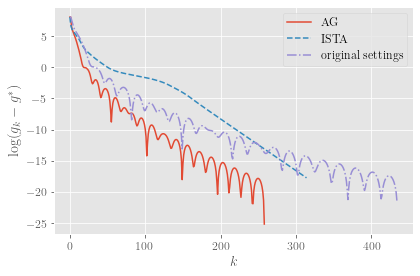

In [16]:
obj_min_val = cp.min(
    cp.array([
        cp.min(obj_val),
        cp.min(obj_val1),
        cp.min(obj_val_Ghadimi),
        cp.min(obj_val_FISTA_UAG),
        cp.min(obj_val_FISTA_ISTA),
        cp.min(obj_val_UAG_restarting)
    ]))

#plt.plot((obj_val - cp.min(obj_val))[:800]/(cp.max(obj_val) - cp.min(obj_val)), linestyle="-", label = "AG")
#plt.plot((obj_val1 - cp.min(obj_val))[:800]/(cp.max(obj_val) - cp.min(obj_val)), linestyle="--", label = "ISTA")
plt.plot(cp.log((obj_val - obj_min_val)).get(), linestyle="-", label="AG")
plt.plot(cp.log((obj_val1 - obj_min_val)).get(), linestyle="--", label="ISTA")
plt.plot(cp.log((obj_val_Ghadimi - obj_min_val)).get(),
         linestyle="-.",
         label="original settings")
#plt.plot(cp.log((obj_val_UAG_restarting - obj_min_val)).get(), linestyle=":", label = "restarting AG") # this is to plot restarting AG
#plt.plot(cp.log((obj_val_FISTA_UAG - obj_min_val)).get(), linestyle="-.", label = "FISTA UAG")
#plt.plot(cp.log((obj_val_FISTA_ISTA - obj_min_val)).get(), linestyle="-.", label = "FISTA ISTA")
#plt.plot(cp.log(obj_val_ORIGINAL[:30]), label = "beta")
#plt.plot(cp.log(obj_val_AG[:30]), label = "beta_ag")
#plt.ylim(0, 1)
# plt.tick_params(axis='x', colors='silver') # DELETE
# plt.tick_params(axis='y', colors='silver') # DELETE
plt.ylabel(r'$\log(g_k-g^*)$')
plt.xlabel(r'$k$')
plt.legend()
plt.tight_layout()
plt.savefig('LM_obj_fig_SCAD.eps', format='eps', dpi=600)
plt.show()
#print("This is what happened with increasing betas: ", cp.array([2050.7388880375, 2050.7388880375, 1148.0741547553168, 702.0987572946106, 588.7055803028516, 538.7139345033852, 500.6287437744593, 468.27573733169754, 439.4799794672321, 413.2341692396099, 389.0096278521058, 366.4725488794078, 345.39473400721465, 325.7409807351111, 307.387003665376, 290.3965750547894, 274.5671829642562, 259.9258959926792, 246.48149615564452, 234.0487644297288]))
#print("This is what happened with constant 1/2L for beta: ", cp.array([2050.7388880375, 2050.7388880375, 1168.655414789768, 790.6786360672963, 644.9112958686272, 584.4087805011285, 550.0076209659103, 522.9020226033148, 498.61659519234024, 476.4614441630745, 456.11260266133195, 437.10369350138285, 419.186919055082, 402.19496430491125, 385.997302713978, 370.53913800137553, 355.7585166605587, 341.5857769375897, 328.0689560196295, 315.1558370119047]))
#print("This is what happened with constant 1/L for beta: ", cp.array([2050.7388880375, 2050.7388880375, 761.2294876350554, 603.4379620904775, 546.8236154672117, 506.2126600837244, 472.34528825225533, 442.6153067182697, 415.7098668348939, 391.01863619466377, 368.1361035574547, 346.7650632764726, 326.8766975735645, 308.3232921204849, 291.17264420155567, 275.2124228643331, 260.45187584661835, 246.91762259921708, 234.40482570047328, 222.96334933332432]))
#print("second experiment, beta constant 1/L, alpha vanishing fast **2.5: ", cp.array([2050.7388880375, 2050.7388880375, 775.0199993121475, 608.4546379080134, 552.3381161160129, 514.8620352754225, 483.7850472602639, 456.69487893225613, 432.1110372516879, 409.403927086619, 388.26937883329776, 368.42022639861415, 349.6138389626128, 331.9725900985804, 315.35111808932277, 299.8638880493409, 285.4666445780192, 272.04549925219465, 259.5311076464833, 247.95400322596018]))

In [17]:
print(temp[0])
print(temp[0][:10])

[ 1.27006202  1.96518873 -2.30627833 ...  0.          0.
  0.        ]
[ 1.27006202  1.96518873 -2.30627833  8.18848052 -8.14331107  0.
  0.          0.          0.          0.        ]


## `LM_obj_fig_MCP.eps`: same settings as above, with $\gamma$ set to be $3$

In [18]:
# this cell is for profiling the function
cp.random.seed(0)
N = 1000
SNR = 5.
true_beta = cp.array([2, -2, 8, -8.] + [0] * 2000)
X_cov = toeplitz(.5**cp.arange(2004))
mean = cp.zeros(2004)
X = cp.random.multivariate_normal(mean, X_cov, N)
X -= cp.mean(X, 0).reshape(1, -1)
X /= cp.std(X, 0)
intercept_design_column = cp.ones(N).reshape(N, 1)
X_sim = cp.concatenate((intercept_design_column, X), 1)
true_sigma_sim = cp.sqrt(true_beta.T @ X_cov @ true_beta / SNR)
true_beta_intercept = cp.concatenate((cp.array([
    1.23
]), true_beta))  # here just define the intercept to be 1.23 for simulated data
epsilon = cp.random.normal(0, true_sigma_sim, N)
y_sim = X_sim @ true_beta_intercept + epsilon

cls = LM_SCAD_MCP(
    design_matrix=X_sim,
    outcome=y_sim,
    penalty="MCP",
    _lambda=.6,  # .6 works
    a=3.7,
    gamma=3,
    beta_0="NOT DECLARED",
    tol=1e-5,
    maxit=5000)

#cProfile.run('cls.UAG_LM_SCAD_MCP()')
temp = cls.UAG_LM_SCAD_MCP()
#print(temp)
obj_val = cp.array(temp[3])
obj_val_ORIGINAL = cp.array(temp[4])
obj_val_AG = cp.array(temp[5])

cls = LM_SCAD_MCP(
    design_matrix=X_sim,
    outcome=y_sim,
    penalty="MCP",
    _lambda=.6,  # .6 works
    a=3.7,
    gamma=3,
    beta_0="NOT DECLARED",
    tol=1e-5,
    maxit=5000)

obj_val1 = cp.array(cls.vanilla_proximal()[3])

cls = LM_SCAD_MCP(
    design_matrix=X_sim,
    outcome=y_sim,
    penalty="MCP",
    _lambda=.6,  # .6 works
    a=3.7,
    gamma=3,
    beta_0="NOT DECLARED",
    tol=1e-5,
    maxit=5000)

obj_val_Ghadimi = cp.array(cls.UAG_LM_SCAD_MCP_Ghadimi_parameter()[3])

cls = LM_SCAD_MCP(
    design_matrix=X_sim,
    outcome=y_sim,
    penalty="MCP",
    _lambda=.6,  # .6 works
    a=3.7,
    gamma=3,
    beta_0="NOT DECLARED",
    tol=1e-5,
    maxit=5000)

obj_val_FISTA_UAG = cp.array(cls.Two_step_FISTA_UAG()[3])

cls = LM_SCAD_MCP(
    design_matrix=X_sim,
    outcome=y_sim,
    penalty="MCP",
    _lambda=.6,  # .6 works
    a=3.7,
    gamma=3,
    beta_0="NOT DECLARED",
    tol=1e-5,
    maxit=5000)

obj_val_FISTA_ISTA = cp.array(cls.Two_step_FISTA_ISTA()[3])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


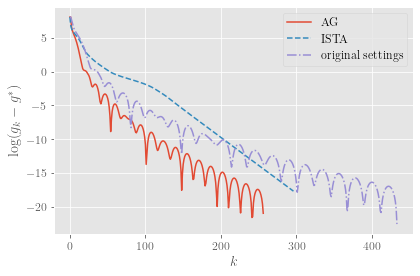

In [19]:
obj_min_val = cp.min(
    cp.array([
        cp.min(obj_val),
        cp.min(obj_val1),
        cp.min(obj_val_Ghadimi),
        cp.min(obj_val_FISTA_UAG),
        cp.min(obj_val_FISTA_ISTA)
    ]))

plt.plot(cp.log((obj_val - obj_min_val)).get(), linestyle="-", label="AG")
plt.plot(cp.log((obj_val1 - obj_min_val)).get(), linestyle="--", label="ISTA")
plt.plot(cp.log((obj_val_Ghadimi - obj_min_val)).get(),
         linestyle="-.",
         label="original settings")

#plt.ylim(0, 1)
# plt.tick_params(axis='x', colors='silver') # DELETE
# plt.tick_params(axis='y', colors='silver') # DELETE
plt.ylabel(r'$\log(g_k-g^*)$')
plt.xlabel(r'$k$')
plt.legend()
plt.tight_layout()
plt.savefig('LM_obj_fig_MCP.eps', format='eps', dpi=600)
plt.show()
#print("This is what happened with increasing betas: ", cp.array([2050.7388880375, 2050.7388880375, 1148.0741547553168, 702.0987572946106, 588.7055803028516, 538.7139345033852, 500.6287437744593, 468.27573733169754, 439.4799794672321, 413.2341692396099, 389.0096278521058, 366.4725488794078, 345.39473400721465, 325.7409807351111, 307.387003665376, 290.3965750547894, 274.5671829642562, 259.9258959926792, 246.48149615564452, 234.0487644297288]))
#print("This is what happened with constant 1/2L for beta: ", cp.array([2050.7388880375, 2050.7388880375, 1168.655414789768, 790.6786360672963, 644.9112958686272, 584.4087805011285, 550.0076209659103, 522.9020226033148, 498.61659519234024, 476.4614441630745, 456.11260266133195, 437.10369350138285, 419.186919055082, 402.19496430491125, 385.997302713978, 370.53913800137553, 355.7585166605587, 341.5857769375897, 328.0689560196295, 315.1558370119047]))
#print("This is what happened with constant 1/L for beta: ", cp.array([2050.7388880375, 2050.7388880375, 761.2294876350554, 603.4379620904775, 546.8236154672117, 506.2126600837244, 472.34528825225533, 442.6153067182697, 415.7098668348939, 391.01863619466377, 368.1361035574547, 346.7650632764726, 326.8766975735645, 308.3232921204849, 291.17264420155567, 275.2124228643331, 260.45187584661835, 246.91762259921708, 234.40482570047328, 222.96334933332432]))
#print("second experiment, beta constant 1/L, alpha vanishing fast **2.5: ", cp.array([2050.7388880375, 2050.7388880375, 775.0199993121475, 608.4546379080134, 552.3381161160129, 514.8620352754225, 483.7850472602639, 456.69487893225613, 432.1110372516879, 409.403927086619, 388.26937883329776, 368.42022639861415, 349.6138389626128, 331.9725900985804, 315.35111808932277, 299.8638880493409, 285.4666445780192, 272.04549925219465, 259.5311076464833, 247.95400322596018]))

In [20]:
print(temp[0])
print(temp[0][:10])

[ 1.27006202  1.96518904 -2.30627831 ...  0.          0.
  0.        ]
[ 1.27006202  1.96518904 -2.30627831  8.18847976 -8.14331041  0.
  0.          0.          0.          0.        ]


## `solution_path_LM_MCP.eps`: MCP solution path with strong rule, settings same as above, $\gamma=1.5,3,10,100$

In [21]:
cp.random.seed(0)
N = 1000
SNR = 5.
true_beta = cp.array([2, -2, 8, -8.] + [0] * 2000)
X_cov = toeplitz(.5**cp.arange(2004))
mean = cp.zeros(2004)
X = cp.random.multivariate_normal(mean, X_cov, N)
X -= cp.mean(X, 0).reshape(1, -1)
X /= cp.std(X, 0)
intercept_design_column = cp.ones(N).reshape(N, 1)
X_sim = cp.concatenate((intercept_design_column, X), 1)
true_sigma_sim = cp.sqrt(true_beta.T @ X_cov @ true_beta / SNR)
true_beta_intercept = cp.concatenate((cp.array([
    1.23
]), true_beta))  # here just define the intercept to be 1.23 for simulated data
epsilon = cp.random.normal(0, true_sigma_sim, N)
y_sim = X_sim @ true_beta_intercept + epsilon

lambda_seq = cp.arange(100) / 100
lambda_seq = lambda_seq[1:]
lambda_seq = lambda_seq[::-1]

LM_beta1 = fit_LM(X_sim[:, 1:],
                  y_sim,
                  lambda_seq=lambda_seq,
                  penalty="MCP",
                  a=3.7,
                  gamma=1.5)
LM_beta2 = fit_LM(X_sim[:, 1:],
                  y_sim,
                  lambda_seq=lambda_seq,
                  penalty="MCP",
                  a=3.7,
                  gamma=3)
LM_beta3 = fit_LM(X_sim[:, 1:],
                  y_sim,
                  lambda_seq=lambda_seq,
                  penalty="MCP",
                  a=3.7,
                  gamma=10)
LM_beta4 = fit_LM(X_sim[:, 1:],
                  y_sim,
                  lambda_seq=lambda_seq,
                  penalty="MCP",
                  a=3.7,
                  gamma=100)

In [22]:
LM_beta1.shape

(100, 2005)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


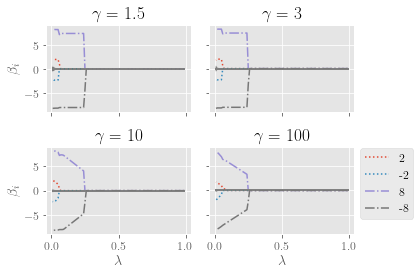

In [23]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot((lambda_seq[:]).get(),
               LM_beta1[1:, 1].get(),
               linestyle=":",
               label="2")
axs[0, 0].plot((lambda_seq[:]).get(),
               LM_beta1[1:, 2].get(),
               linestyle=":",
               label="-2")
axs[0, 0].plot((lambda_seq[:]).get(),
               LM_beta1[1:, 3].get(),
               linestyle="-.",
               label="8")
axs[0, 0].plot((lambda_seq[:]).get(),
               LM_beta1[1:, 4].get(),
               linestyle="-.",
               label="-8")
for i in np.arange(5, LM_beta.shape[1]):
    axs[0, 0].plot((lambda_seq[:]).get(),
                   LM_beta1[1:, i].get(),
                   color="grey",
                   linestyle="-",
                   alpha=.1,
                   linewidth=.3)
#axs[0, 0].set_ylim([-2,2])
#axs[0, 0].legend()
axs[0, 0].set_title(r'$\gamma=1.5$')
axs[0, 1].plot((lambda_seq[:]).get(),
               LM_beta2[1:, 1].get(),
               linestyle=":",
               label="2")
axs[0, 1].plot((lambda_seq[:]).get(),
               LM_beta2[1:, 2].get(),
               linestyle=":",
               label="-2")
axs[0, 1].plot((lambda_seq[:]).get(),
               LM_beta2[1:, 3].get(),
               linestyle="-.",
               label="8")
axs[0, 1].plot((lambda_seq[:]).get(),
               LM_beta2[1:, 4].get(),
               linestyle="-.",
               label="-8")
for i in np.arange(5, LM_beta.shape[1]):
    axs[0, 1].plot((lambda_seq[:]).get(),
                   LM_beta2[1:, i].get(),
                   color="grey",
                   linestyle="-",
                   alpha=.1,
                   linewidth=.3)
#axs[0, 1].set_ylim([-2,2])
#axs[0, 1].legend()
axs[0, 1].set_title(r'$\gamma=3$')
axs[1, 0].plot((lambda_seq[:]).get(),
               LM_beta3[1:, 1].get(),
               linestyle=":",
               label="2")
axs[1, 0].plot((lambda_seq[:]).get(),
               LM_beta3[1:, 2].get(),
               linestyle=":",
               label="-2")
axs[1, 0].plot((lambda_seq[:]).get(),
               LM_beta3[1:, 3].get(),
               linestyle="-.",
               label="8")
axs[1, 0].plot((lambda_seq[:]).get(),
               LM_beta3[1:, 4].get(),
               linestyle="-.",
               label="-8")
for i in np.arange(5, LM_beta.shape[1]):
    axs[1, 0].plot((lambda_seq[:]).get(),
                   LM_beta3[1:, i].get(),
                   color="grey",
                   linestyle="-",
                   alpha=.1,
                   linewidth=.3)
#axs[1, 0].set_ylim([-2,2])
#axs[1, 0].legend()
axs[1, 0].set_title(r'$\gamma=10$')
axs[1, 1].plot((lambda_seq[:]).get(),
               LM_beta4[1:, 1].get(),
               linestyle=":",
               label="2")
axs[1, 1].plot((lambda_seq[:]).get(),
               LM_beta4[1:, 2].get(),
               linestyle=":",
               label="-2")
axs[1, 1].plot((lambda_seq[:]).get(),
               LM_beta4[1:, 3].get(),
               linestyle="-.",
               label="8")
axs[1, 1].plot((lambda_seq[:]).get(),
               LM_beta4[1:, 4].get(),
               linestyle="-.",
               label="-8")
for i in np.arange(5, LM_beta.shape[1]):
    axs[1, 1].plot((lambda_seq[:]).get(),
                   LM_beta4[1:, i].get(),
                   color="grey",
                   linestyle="-",
                   alpha=.1,
                   linewidth=.3)
#axs[1, 1].set_ylim([-2,2])
#axs[1, 1].legend()
axs[1, 1].set_title(r'$\gamma=100$')

for ax in axs.flat:
    ax.set(xlabel=r'$\lambda$', ylabel=r'$\beta_i$')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
#     ax.tick_params(axis='x', colors='silver') # DELETE
#     ax.tick_params(axis='y', colors='silver') # DELETE

lgd = plt.legend(loc=2, bbox_to_anchor=(1, 1.05), ncol=1, borderaxespad=0.5)
plt.tight_layout()

plt.savefig('solution_path_LM_MCP.eps', format='eps', dpi=600, pad_inches=2)
plt.show()

## comparison of number of iterations required for difference of objective values from optimal values to reach $e^{2}$, with SNR=$3$, Toeplitz being $0.1,0.5,0.9$, and N=$200,500,1000,3000$, p=$2050$ with each $10$ coefficients simulated from $N(.5,1),N(5,2),N(10,3),N(20,4),N(50,5)$, sparsely located in the array, with $500$ zeros in-between 


In [24]:
def simulator(seed,
              SNR,
              Toeplitz,
              N,
              penalty,
              _lambda,
              a=3.7,
              gamma=3.,
              target=-7):
    cp.random.seed(seed)
    true_beta = cp.array(
        cp.random.normal(.5, 1, 10).tolist() + [0.] * 500 +
        cp.random.normal(5, 2, 10).tolist() + [0.] * 500 +
        cp.random.normal(10, 3, 10).tolist() + [0.] * 500 +
        cp.random.normal(20, 4, 10).tolist() + [0.] * 500 +
        cp.random.normal(50, 5, 10).tolist())
    X_cov = toeplitz(Toeplitz**cp.arange(true_beta.shape[0]))
    mean = cp.zeros(true_beta.shape[0])
    X = cp.random.multivariate_normal(mean, X_cov, N)
    X -= cp.mean(X, 0).reshape(1, -1)
    X /= cp.std(X, 0)
    intercept_design_column = cp.ones(N).reshape(N, 1)
    X_sim = cp.concatenate((intercept_design_column, X), 1)
    true_sigma_sim = cp.sqrt(true_beta.T @ X_cov @ true_beta / SNR)
    true_beta_intercept = cp.concatenate(
        (cp.array([0]), true_beta
         ))  # here just define the intercept to be 1.23 for simulated data
    epsilon = cp.random.normal(0, true_sigma_sim, N)
    y_sim = X_sim @ true_beta_intercept + epsilon

    cls = LM_SCAD_MCP(design_matrix=X_sim,
                      outcome=y_sim,
                      penalty=penalty,
                      _lambda=_lambda,
                      a=a,
                      gamma=gamma,
                      beta_0="NOT DECLARED",
                      tol=1e-4,
                      maxit=5000)
    obj_val_AG = cp.array(cls.UAG_LM_SCAD_MCP()[3])
    s = """cls = LM_SCAD_MCP(design_matrix = X_sim,outcome = y_sim,penalty = penalty,_lambda = _lambda,a=a,gamma=gamma,beta_0="NOT DECLARED",tol=1e-4,maxit=5000);cls.UAG_LM_SCAD_MCP()"""
    imports_and_vars = globals()
    imports_and_vars.update(locals())
    _, AG_time = timeit.Timer(stmt=s, globals=imports_and_vars).autorange()

    cls = LM_SCAD_MCP(design_matrix=X_sim,
                      outcome=y_sim,
                      penalty=penalty,
                      _lambda=_lambda,
                      a=a,
                      gamma=gamma,
                      beta_0="NOT DECLARED",
                      tol=1e-4,
                      maxit=5000)
    obj_val_ISTA = cp.array(cls.vanilla_proximal()[3])
    s = """cls = LM_SCAD_MCP(design_matrix = X_sim,outcome = y_sim,penalty = penalty,_lambda = _lambda,a=a,gamma=gamma,beta_0="NOT DECLARED",tol=1e-4,maxit=5000);cls.vanilla_proximal()"""
    imports_and_vars = globals()
    imports_and_vars.update(locals())
    _, ISTA_time = timeit.Timer(stmt=s, globals=imports_and_vars).autorange()

    cls = LM_SCAD_MCP(design_matrix=X_sim,
                      outcome=y_sim,
                      penalty=penalty,
                      _lambda=_lambda,
                      a=a,
                      gamma=gamma,
                      beta_0="NOT DECLARED",
                      tol=1e-4,
                      maxit=5000)
    obj_val_Ghadimi = cp.array(cls.UAG_LM_SCAD_MCP_Ghadimi_parameter()[3])

    s = """cls = LM_SCAD_MCP(design_matrix = X_sim,outcome = y_sim,penalty = penalty,_lambda = _lambda,a=a,gamma=gamma,beta_0="NOT DECLARED",tol=1e-4,maxit=5000,L_convex=1.);cls.coordinate_descent()"""
    imports_and_vars = globals()
    imports_and_vars.update(locals())
    _, coord_time = timeit.Timer(stmt=s, globals=imports_and_vars).autorange()

    obj_min_val = cp.min(
        cp.array([
            cp.min(obj_val_AG),
            cp.min(obj_val_ISTA),
            cp.min(obj_val_Ghadimi)
        ]))

    obj_val_AG -= obj_min_val
    obj_val_ISTA -= obj_min_val
    obj_val_Ghadimi -= obj_min_val

    #     obj_val_AG, obj_val_ISTA, obj_val_Ghadimi = cp.log(obj_val_AG), cp.log(obj_val_ISTA), cp.log(obj_val_Ghadimi)
    #     target_min = cp.min(cp.array([cp.min(obj_val_AG),cp.min(obj_val_ISTA),cp.min(obj_val_Ghadimi)]))
    results = cp.array([cp.inf] * 6)
    if cp.any(obj_val_AG <= target) == True:
        results[0] = cp.min(cp.where(obj_val_AG <= target)[0])
    if cp.any(obj_val_ISTA <= target) == True:
        results[1] = cp.min(cp.where(obj_val_ISTA <= target)[0])
    if cp.any(obj_val_Ghadimi <= target) == True:
        results[2] = cp.min(cp.where(obj_val_Ghadimi <= target)[0])
    results[3] = AG_time
    results[4] = ISTA_time
    results[5] = coord_time
    # returns number of iterations for AG, ISTA, Ghadimi settings
    return results

### SCAD `SCAD_sim_results.npy`

In [ ]:
SCAD_sim_results = cp.zeros((3, 4, 100, 6))

for i, j, seed in itertools.product(range(3), range(4), range(100)):
    SCAD_sim_results[i, j, seed, :] = simulator(seed=seed,
                                                SNR=5.,
                                                Toeplitz=[0.1, 0.5, 0.9][i],
                                                N=[200, 500, 1000, 3000][j],
                                                penalty="SCAD",
                                                _lambda=.2,
                                                a=3.7,
                                                gamma=3.,
                                                target=cp.exp(3))

cp.save("SCAD_sim_results", SCAD_sim_results)

In [ ]:
#  SCAD_sim_results_mean = cp.median(SCAD_sim_results, 2)
# print("Median:")
# print("AG: ",SCAD_sim_results_mean[...,0])
# print("ISTA: ",SCAD_sim_results_mean[...,1])
# print("original settings: ",SCAD_sim_results_mean[...,2])
# SCAD_sim_results_se = mad(SCAD_sim_results.get(), 2)*1.4826
# print("Consistent MAD: ")
# print("AG: ",SCAD_sim_results_se[...,0])
# print("ISTA: ",SCAD_sim_results_se[...,1])
# print("original settings: ",SCAD_sim_results_se[...,2])

# SCAD_sim_results_mean = cp.mean(SCAD_sim_results, 2)
# print("Mean:")
# print("AG: ",SCAD_sim_results_mean[...,0])
# print("ISTA: ",SCAD_sim_results_mean[...,1])
# print("original settings: ",SCAD_sim_results_mean[...,2])
# SCAD_sim_results_se = cp.std(SCAD_sim_results.get(), 2)
# print("se: ")
# print("AG: ",SCAD_sim_results_se[...,0])
# print("ISTA: ",SCAD_sim_results_se[...,1])
# print("original settings: ",SCAD_sim_results_se[...,2])

### MCP `MCP_sim_results.npy`

In [ ]:
MCP_sim_results = cp.zeros((3, 4, 100, 6))

for i, j, seed in itertools.product(range(3), range(4), range(100)):
    MCP_sim_results[i, j, seed, :] = simulator(seed=seed,
                                               SNR=5.,
                                               Toeplitz=[0.1, 0.5, 0.9][i],
                                               N=[200, 500, 1000, 3000][j],
                                               penalty="MCP",
                                               _lambda=.2,
                                               a=3.7,
                                               gamma=3.,
                                               target=cp.exp(3))

cp.save("MCP_sim_results", MCP_sim_results)

In [ ]:
# MCP_sim_results_mean = cp.median(MCP_sim_results, 2)
# print("Median:")
# print("AG: ",MCP_sim_results_mean[...,0])
# print("ISTA: ",MCP_sim_results_mean[...,1])
# print("original settings: ",MCP_sim_results_mean[...,2])
# MCP_sim_results_se = mad(MCP_sim_results.get(), 2)*1.4826
# print("Consistent MAD: ")
# print("AG: ",MCP_sim_results_se[...,0])
# print("ISTA: ",MCP_sim_results_se[...,1])
# print("original settings: ",MCP_sim_results_se[...,2])

# MCP_sim_results_mean = cp.mean(MCP_sim_results, 2)
# print("Mean:")
# print("AG: ",MCP_sim_results_mean[...,0])
# print("ISTA: ",MCP_sim_results_mean[...,1])
# print("original settings: ",MCP_sim_results_mean[...,2])
# MCP_sim_results_se = cp.std(MCP_sim_results.get(), 2)
# print("se: ")
# print("AG: ",MCP_sim_results_se[...,0])
# print("ISTA: ",MCP_sim_results_se[...,1])
# print("original settings: ",MCP_sim_results_se[...,2])

## performance of signal recovery ($2-$norm, $\infty-$norm, PPV/NPV) based on best testing set performance, with SNR=$1,3,7,10$, Toeplitz being $0.1,0.5,0.9$, and N=$1000$, p=$2050$ with each $10$ coefficients simulated from $N(.5,1),N(5,2),N(10,3),N(20,4),N(50,5)$, sparsely located in the array, with $500$ zeros in-between 

### SCAD `results_SCAD_signal_recovery.npy`

In [ ]:
data = robjects.r("""
library(MASS)
x = array(0, dim = c(4, 3, 100, 2000, 2052)) # first column will be y
true_betas = array(0, dim = c(4,3,100,2051))
for (i in 1:4){
for (j in 1:3){
for (seed in 1:100){
set.seed(seed)
true_beta = c(rnorm(10, .5, 1), rep(0,500), rnorm(10, 5, 2), rep(0,500), rnorm(10, 10, 3), rep(0,500), rnorm(10, 20, 4), rep(0,500), rnorm(10, 50, 5))
true_betas[i,j,seed,-1] = true_beta
X_cov = toeplitz((c(0.1,0.5,0.9)[j])^c(0:(length(true_beta)-1)))
X_temp = mvrnorm(2000, rep(0,2050), X_cov)
X_temp = scale(X_temp)
x[i,j,seed,,-c(1,2)] = X_temp
true_sigma_sim = sqrt(t(true_beta)%*%X_cov%*%true_beta/(c(1,3,7,10)[i]))
y_temp = X_temp%*%true_beta + rnorm(2000,0,true_sigma_sim) # here I simply let the true intercept coefficient to be 0
x[i,j,seed,,2] = 1
x[i,j,seed,,1] = y_temp
}
}
}
""")
print("simulating from R done!")
SCAD_sim = np.array(robjects.r["x"])
SCAD_true_beta = np.array(robjects.r["true_betas"])
results_SCAD_signal_recovery = cp.zeros((4, 3, 100, 5))

for i, j, seed in itertools.product(range(4), range(3), range(100)):
    # import to GPU only when it's needed
    X_sim = cp.array(SCAD_sim[i, j, seed, :1000, 1:])
    y_sim = cp.array(SCAD_sim[i, j, seed, :1000, 0])
    lambda_seq = cp.linspace(lambda_max_LM(X_sim[:, 1:], y_sim),
                             0,
                             num=50,
                             endpoint=False)
    temp_beta = fit_LM(X_sim[:, 1:],
                       y_sim,
                       lambda_seq=lambda_seq,
                       penalty="SCAD",
                       a=3.7,
                       gamma=3.)
    # testing which beta performs the best
    testing_X = cp.array(SCAD_sim[i, j, seed, 1000:, 1:])
    testing_y = cp.array(SCAD_sim[i, j, seed, 1000:, 0])
    testing_temp = testing_X @ temp_beta.T - testing_y.reshape(
        -1, 1)  # each column is error for each beta
    testing_error = cp.linalg.norm(testing_temp, axis=0)
    # choose the right beta
    beta_ind = cp.argmin(testing_error)
    chosen_beta = temp_beta[beta_ind, :]
    temp_true_beta = cp.array(SCAD_true_beta[i, j, seed, :])
    norm2_error = (cp.linalg.norm(chosen_beta - temp_true_beta, 2) /
                   cp.linalg.norm(temp_true_beta, 2))**2
    norminfity_error = cp.linalg.norm(chosen_beta - temp_true_beta, cp.inf)
    NPV = cp.sum(
        cp.logical_and(chosen_beta == 0., temp_true_beta == 0.) * 1.) / cp.sum(
            (chosen_beta == 0.) * 1.)
    PPV = cp.sum(
        cp.logical_and(chosen_beta != 0., temp_true_beta != 0.) * 1.) / cp.sum(
            (chosen_beta != 0.) * 1.)
    active_set_cardi = cp.sum((chosen_beta != 0.) * 1.)
    results_SCAD_signal_recovery[i, j, seed, 0] = norm2_error
    results_SCAD_signal_recovery[i, j, seed, 1] = norminfity_error
    results_SCAD_signal_recovery[i, j, seed, 2] = PPV
    results_SCAD_signal_recovery[i, j, seed, 3] = NPV
    results_SCAD_signal_recovery[i, j, seed, 4] = active_set_cardi

cp.save("results_SCAD_signal_recovery", results_SCAD_signal_recovery)

In [ ]:
# results_SCAD_signal_recovery_mean = cp.mean(results_SCAD_signal_recovery, 2)
# print("Sample mean:")
# print("2-norm: ",results_SCAD_signal_recovery_mean[...,0])
# print("infinity-norm: ",results_SCAD_signal_recovery_mean[...,1])
# print("PPV: ",results_SCAD_signal_recovery_mean[...,2])
# print("NPV: ",results_SCAD_signal_recovery_mean[...,3])
# results_SCAD_signal_recovery_se = cp.std(results_SCAD_signal_recovery, 2)
# print("Sample se:")
# print("2-norm: ",results_SCAD_signal_recovery_se[...,0])
# print("infinity-norm: ",results_SCAD_signal_recovery_se[...,1])
# print("PPV: ",results_SCAD_signal_recovery_se[...,2])
# print("NPV: ",results_SCAD_signal_recovery_se[...,3])

# results_SCAD_signal_recovery_median = cp.median(results_SCAD_signal_recovery, 2)
# print("Sample median:")
# print("2-norm: ",results_SCAD_signal_recovery_median[...,0])
# print("infinity-norm: ",results_SCAD_signal_recovery_median[...,1])
# print("PPV: ",results_SCAD_signal_recovery_median[...,2])
# print("NPV: ",results_SCAD_signal_recovery_median[...,3])
# results_SCAD_signal_recovery_mad = mad(results_SCAD_signal_recovery.get(), 2)
# print("Sample MAD:")
# print("2-norm: ",results_SCAD_signal_recovery_mad[...,0])
# print("infinity-norm: ",results_SCAD_signal_recovery_mad[...,1])
# print("PPV: ",results_SCAD_signal_recovery_mad[...,2])
# print("NPV: ",results_SCAD_signal_recovery_mad[...,3])

### MCP `results_MCP_signal_recovery.npy`

In [ ]:
# data generation from R end is the same as above, so it's not a good idea to do it again.
# data = robjects.r("""
# library(MASS)
# x = array(0, dim = c(4, 3, 100, 2000, 2052)) # first column will be y
# true_betas = array(0, dim = c(4,3,100,2051))
# for (i in 1:4){
# for (j in 1:3){
# for (seed in 1:100){
# set.seed(seed)
# true_beta = c(rnorm(10, .5, 1), rep(0,500), rnorm(10, 5, 2), rep(0,500), rnorm(10, 10, 3), rep(0,500), rnorm(10, 20, 4), rep(0,500), rnorm(10, 50, 5))
# true_betas[i,j,seed,-1] = true_beta
# X_cov = toeplitz((c(0.1,0.5,0.9)[j])^c(0:(length(true_beta)-1)))
# X_temp = mvrnorm(2000, rep(0,2050), X_cov)
# X_temp = scale(X_temp)
# x[i,j,seed,,-c(1,2)] = X_temp
# true_sigma_sim = sqrt(t(true_beta)%*%X_cov%*%true_beta/(c(1,3,7,10)[i]))
# y_temp = X_temp%*%true_beta + rnorm(2000,0,true_sigma_sim) # here I simply let the true intercept coefficient to be 0
# x[i,j,seed,,2] = 1
# x[i,j,seed,,1] = y_temp
# }
# }
# }
# """)
# print("simulating from R done!")
MCP_sim = SCAD_sim.copy()  #np.array(robjects.r["x"])
MCP_true_beta = SCAD_true_beta.copy()  #np.array(robjects.r["true_betas"])
results_MCP_signal_recovery = cp.zeros((4, 3, 100, 5))

for i, j, seed in itertools.product(range(4), range(3), range(100)):
    # import to GPU only when it's needed
    X_sim = cp.array(MCP_sim[i, j, seed, :1000, 1:])
    y_sim = cp.array(MCP_sim[i, j, seed, :1000, 0])
    lambda_seq = cp.linspace(lambda_max_LM(X_sim[:, 1:], y_sim),
                             0,
                             num=50,
                             endpoint=False)
    temp_beta = fit_LM(X_sim[:, 1:],
                       y_sim,
                       lambda_seq=lambda_seq,
                       penalty="MCP",
                       a=3.7,
                       gamma=3.)
    # testing which beta performs the best
    testing_X = cp.array(MCP_sim[i, j, seed, 1000:, 1:])
    testing_y = cp.array(MCP_sim[i, j, seed, 1000:, 0])
    testing_temp = testing_X @ temp_beta.T - testing_y.reshape(
        -1, 1)  # each column is error for each beta
    testing_error = cp.linalg.norm(testing_temp, axis=0)
    # choose the right beta
    beta_ind = cp.argmin(testing_error)
    chosen_beta = temp_beta[beta_ind, :]
    temp_true_beta = cp.array(MCP_true_beta[i, j, seed, :])
    norm2_error = (cp.linalg.norm(chosen_beta - temp_true_beta, 2) /
                   cp.linalg.norm(temp_true_beta, 2))**2
    norminfity_error = cp.linalg.norm(chosen_beta - temp_true_beta, cp.inf)
    NPV = cp.sum(
        cp.logical_and(chosen_beta == 0., temp_true_beta == 0.) * 1.) / cp.sum(
            (chosen_beta == 0.) * 1.)
    PPV = cp.sum(
        cp.logical_and(chosen_beta != 0., temp_true_beta != 0.) * 1.) / cp.sum(
            (chosen_beta != 0.) * 1.)
    active_set_cardi = cp.sum((chosen_beta != 0.) * 1.)
    results_MCP_signal_recovery[i, j, seed, 0] = norm2_error
    results_MCP_signal_recovery[i, j, seed, 1] = norminfity_error
    results_MCP_signal_recovery[i, j, seed, 2] = PPV
    results_MCP_signal_recovery[i, j, seed, 3] = NPV
    results_MCP_signal_recovery[i, j, seed, 4] = active_set_cardi

cp.save("results_MCP_signal_recovery", results_MCP_signal_recovery)

In [ ]:
# results_MCP_signal_recovery_mean = cp.mean(results_MCP_signal_recovery, 2)
# print("Sample mean:")
# print("2-norm: ",results_MCP_signal_recovery_mean[...,0])
# print("infinity-norm: ",results_MCP_signal_recovery_mean[...,1])
# print("PPV: ",results_MCP_signal_recovery_mean[...,2])
# print("NPV: ",results_MCP_signal_recovery_mean[...,3])
# results_MCP_signal_recovery_se = cp.std(results_MCP_signal_recovery, 2)
# print("Sample se:")
# print("2-norm: ",results_MCP_signal_recovery_se[...,0])
# print("infinity-norm: ",results_MCP_signal_recovery_se[...,1])
# print("PPV: ",results_MCP_signal_recovery_se[...,2])
# print("NPV: ",results_MCP_signal_recovery_se[...,3])

# results_MCP_signal_recovery_median = cp.median(results_MCP_signal_recovery, 2)
# print("Sample median:")
# print("2-norm: ",results_MCP_signal_recovery_median[...,0])
# print("infinity-norm: ",results_MCP_signal_recovery_median[...,1])
# print("PPV: ",results_MCP_signal_recovery_median[...,2])
# print("NPV: ",results_MCP_signal_recovery_median[...,3])
# results_MCP_signal_recovery_mad = mad(results_MCP_signal_recovery.get(), 2)
# print("Sample MAD:")
# print("2-norm: ",results_MCP_signal_recovery_mad[...,0])
# print("infinity-norm: ",results_MCP_signal_recovery_mad[...,1])
# print("PPV: ",results_MCP_signal_recovery_mad[...,2])
# print("NPV: ",results_MCP_signal_recovery_mad[...,3])

# R ncvreg simulations
## SCAD

In [ ]:
# R_SCAD_signal=np.load("R_results_SCAD_signal_recovery.npy")
# R_SCAD_signal=np.reshape(R_SCAD_signal, (4,3,100,4),"F") # keep array dimension true
# R_SCAD_signal = cp.array(R_SCAD_signal)

# R_SCAD_signal_mean = cp.mean(R_SCAD_signal, 2)
# print("Sample mean:")
# print("2-norm: ",R_SCAD_signal_mean[...,0])
# print("infinity-norm: ",R_SCAD_signal_mean[...,1])
# print("PPV: ",R_SCAD_signal_mean[...,2])
# print("NPV: ",R_SCAD_signal_mean[...,3])
# R_SCAD_signal_se = cp.std(R_SCAD_signal, 2)
# print("Sample se:")
# print("2-norm: ",R_SCAD_signal_se[...,0])
# print("infinity-norm: ",R_SCAD_signal_se[...,1])
# print("PPV: ",R_SCAD_signal_se[...,2])
# print("NPV: ",R_SCAD_signal_se[...,3])

# R_SCAD_signal_median = cp.median(R_SCAD_signal, 2)
# print("Sample median:")
# print("2-norm: ",R_SCAD_signal_median[...,0])
# print("infinity-norm: ",R_SCAD_signal_median[...,1])
# print("PPV: ",R_SCAD_signal_median[...,2])
# print("NPV: ",R_SCAD_signal_median[...,3])
# R_SCAD_signal_mad = mad(R_SCAD_signal.get(), 2)
# print("Sample MAD:")
# print("2-norm: ",R_SCAD_signal_mad[...,0])
# print("infinity-norm: ",R_SCAD_signal_mad[...,1])
# print("PPV: ",R_SCAD_signal_mad[...,2])
# print("NPV: ",R_SCAD_signal_mad[...,3])

## MCP

In [ ]:
# R_MCP_signal=np.load("R_results_MCP_signal_recovery.npy")
# R_MCP_signal=np.reshape(R_MCP_signal, (4,3,100,4),"F") # keep array dimension true
# R_MCP_signal = cp.array(R_MCP_signal)

# R_MCP_signal_mean = cp.mean(R_MCP_signal, 2)
# print("Sample mean:")
# print("2-norm: ",R_MCP_signal_mean[...,0])
# print("infinity-norm: ",R_MCP_signal_mean[...,1])
# print("PPV: ",R_MCP_signal_mean[...,2])
# print("NPV: ",R_MCP_signal_mean[...,3])
# R_MCP_signal_se = cp.std(R_MCP_signal, 2)
# print("Sample se:")
# print("2-norm: ",R_MCP_signal_se[...,0])
# print("infinity-norm: ",R_MCP_signal_se[...,1])
# print("PPV: ",R_MCP_signal_se[...,2])
# print("NPV: ",R_MCP_signal_se[...,3])

# R_MCP_signal_median = cp.median(R_MCP_signal, 2)
# print("Sample median:")
# print("2-norm: ",R_MCP_signal_median[...,0])
# print("infinity-norm: ",R_MCP_signal_median[...,1])
# print("PPV: ",R_MCP_signal_median[...,2])
# print("NPV: ",R_MCP_signal_median[...,3])
# R_MCP_signal_mad = mad(R_MCP_signal.get(), 2)
# print("Sample MAD:")
# print("2-norm: ",R_MCP_signal_mad[...,0])
# print("infinity-norm: ",R_MCP_signal_mad[...,1])
# print("PPV: ",R_MCP_signal_mad[...,2])
# print("NPV: ",R_MCP_signal_mad[...,3])